In [1]:
!nvidia-smi

Sun Apr 17 11:12:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
import sys
drive.mount('/content/drive')
#设置路径
sys.path.append('/content/drive/MyDrive/Colab Notebooks')

Mounted at /content/drive


In [3]:
! pip install transformers==4.0.1

     |████████████████████████████████| 1.4 MB 5.3 MB/s 
     |████████████████████████████████| 895 kB 39.9 MB/s 
     |████████████████████████████████| 2.9 MB 34.4 MB/s 


In [4]:
import torch
import random
import numpy as np
import pandas as pd
from tqdm import tqdm

config = {
    'train_file_path':'/content/drive/MyDrive/Colab Notebooks/dataset/ESIM/train.json',
    'dev_file_path':'/content/drive/MyDrive/Colab Notebooks/dataset/ESIM/dev.json',
    'test_file_path':'/content/drive/MyDrive/Colab Notebooks/dataset/ESIM/test.json',
    'embedding_file_path':'/content/drive/MyDrive/Colab Notebooks/dataset/sgns.weibo.word.bz2',
    'train_val_ratio':0.1,
    'vocab_size':30000,
    'batch_size':64,
    'num_epochs':1,
    'learning_rate':2e-5,
    'logging_step':500,
    'seed':2022
}

config['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'

def seed_everything(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  return seed

seed_everything(config['seed'])

2022

In [5]:
import json
def read_data(path):
  sentence_a = []
  sentence_b = []
  labels = []
  with open(path, 'r', encoding='utf8') as f:
    for line in tqdm(f.readlines(), desc='Reading data'):
      line = json.loads(line)
      sentence_a.append(line['sentence1'])
      sentence_b.append(line['sentence2'])
      labels.append(int(line['label']))
  
  df = pd.DataFrame(zip(sentence_a, sentence_b, labels), columns=['text_a','text_b','labels'])
  return df

In [6]:
# 复习一下zip函数:
# 这里有两个元组()，每个元组有两个句子，一个label
datas = [([1,2,3],[4,5,6],1),([777,888,999],[321,543,654],0)]
# 取出列表中每个元素（元组）
print(*datas)
print(zip(*datas))
# 把 datas 中的同一类别的放在一起
print(list(zip(*datas)))

([1, 2, 3], [4, 5, 6], 1) ([777, 888, 999], [321, 543, 654], 0)
[([1, 2, 3], [777, 888, 999]), ([4, 5, 6], [321, 543, 654]), (1, 0)]


In [7]:
train_df = read_data(config['train_file_path'])

Reading data: 100%|██████████| 34334/34334 [00:00<00:00, 96339.38it/s]


In [8]:
train_df.head()

,text_a,text_b,labels
0,蚂蚁借呗等额还款可以换成先息后本吗,借呗有先息到期还本吗,0
1,蚂蚁花呗说我违约一次,蚂蚁花呗违约行为是什么,0
2,帮我看一下本月花呗账单有没有结清,下月花呗账单,0
3,蚂蚁借呗多长时间综合评估一次,借呗得评估多久,0
4,我的花呗账单是***，还款怎么是***,我的花呗，月结出来说让我还***元，我自己算了一下详细名单我应该还***元,1


In [9]:
dev_df = read_data(config['dev_file_path'])

Reading data: 100%|██████████| 4316/4316 [00:00<00:00, 86185.29it/s]


In [10]:
dev_df.head()

,text_a,text_b,labels
0,双十一花呗提额在哪,里可以提花呗额度,0
1,花呗支持高铁票支付吗,为什么友付宝不支持花呗付款,0
2,我的蚂蚁花呗支付金额怎么会有限制,我到支付宝实体店消费用花呗支付受金额限制,1
3,为什么有花呗额度不能分期付款,花呗分期额度不足,0
4,赠品不能设置用花呗付款,怎么不能花呗分期付款,0


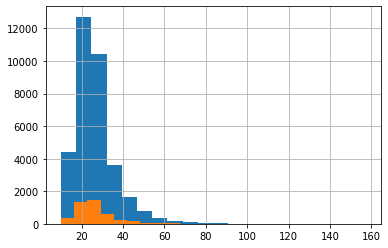

In [11]:
(train_df.text_a.str.len() + train_df.text_b.str.len()).hist(bins = 20);
(dev_df.text_a.str.len() + dev_df.text_b.str.len()).hist(bins = 20);

In [12]:
# 64能容纳99%的句子长度
(train_df.text_a.str.len() + train_df.text_b.str.len()).quantile(0.99)

64.0

In [13]:
# 处理文件，生层词表放回关于train_df[train.json + dev.json],test_df
from collections import Counter
import jieba
import bz2
def preprocess(config):
  def convert2df(file_path, dataset='train'):
    sentence_a = []
    sentence_b = []
    labels = []
    with open(file_path, 'r', encoding='utf8') as f:
      for line in tqdm(f.readlines(), desc=f'Reading {dataset} data'):
        line = json.loads(line)
        sentence_a.append(line['sentence1'])
        sentence_b.append(line['sentence2'])
        if dataset != 'test':
          labels.append(int(line['label']))
        else:
          labels.append(0)
        # tokens为每次新加入的句子
        tokens = list(jieba.cut(sentence_a[-1])) + list(jieba.cut(sentence_b[-1])) 
        # print('tokens:',tokens)
        # tokens: ['蚂蚁', '花', '呗', '说', '我', '违约', '一次', '蚂蚁', '花', '呗', '违约', '行为', '是', '什么']
        token_counter.update(tokens)
    df = pd.DataFrame(zip(sentence_a,sentence_b,labels),columns=['text_a','text_b','labels'])
    return df
  
  token_counter = Counter()

  train_df = convert2df(config['train_file_path'],'train')
  dev_df = convert2df(config['dev_file_path'],'dev')
  test_df = convert2df(config['test_file_path'],'test')

  train_df = train_df.append(dev_df)
  vocab = set(token for token, _ in token_counter.most_common(config['vocab_size']))
  # print('vocab:',vocab)
  # vocab: {'城', '帮不上', '百度', '钱分', '会加分', '我晚', '手机短信'.......}
  return train_df, test_df, vocab



In [14]:
train_df, test_df, vocab = preprocess(config)

Reading train data:   0%|          | 0/34334 [00:00<?, ?it/s]Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 1.266 seconds.
Prefix dict has been built successfully.
Reading test data: 100%|██████████| 3861/3861 [00:01<00:00, 2828.69it/s]


In [36]:
# TextCNN 词表对应成向量
def get_embedding(vocab, embedding_file_path):
  print('processing embedding file, please wait...')

  token2embedding = {}

  with bz2.open(embedding_file_path) as f:
    token_vectors = f.readlines()
    # print('token_vectors:',list(token_vectors[0:10]))
    # token_vectors: [b'195202 300\n', b'\xef\xbc\x8c 0.094386 -0.200944 -0.030828 0.277130 ... 0.126182 -0.554329 -0.328050 \n', b'......\n'...]
    meta_info = token_vectors[0].split()
    # print('meta_info:',meta_info)
    # meta_info: [b'195202', b'300']
    print(f'{meta_info[0]} tokens in embedding file in total, vector size is {meta_info[-1]}')

    for line in tqdm(token_vectors[1:]):
      line = line.split()
      token = line[0].decode('utf8')
      # print('token:',token)
      # token: ！
      # token: 可以
      # token: 等
      # ...
      vector = line[1:]
      if token in vocab:
        token2embedding[token] = [float(num) for num in vector]
        # print('token2embedding[token]:',token2embedding[token])
        # token2embedding[token]: [-0.124044, -0.053688, 0.157958, ... -0.127075, -0.020528, 0.032646]
  #从4开始
  token2idx = {token: idx for idx, token in enumerate(token2embedding.keys(),4)}
  UNK, PAD, BOS, EOS = '<unk>', '<pad>', '<bos>', '<eos>'
  token2idx[PAD] = 0 
  token2idx[UNK] = 1
  token2idx[BOS] = 2
  token2idx[EOS] = 3
  idx2token = {idx: token for token, idx in token2idx.items()}
  idx2embedding = {token2idx[token]: embedding for token, embedding in token2embedding.items()}

  idx2embedding[0] = [.0] * int(meta_info[-1])
  idx2embedding[1] = [.0] * int(meta_info[-1])
  idx2embedding[2] = np.random.random(int(meta_info[-1])).tolist()
  idx2embedding[3] = np.random.random(int(meta_info[-1])).tolist()
  emb_mat = [idx2embedding[idx] for idx in range(len(idx2embedding))]

  return torch.tensor(emb_mat, dtype=torch.float), token2idx, len(vocab) + 4

In [37]:
embedding_matrix, token2idx, config['vocab_size'] = get_embedding(vocab, config['embedding_file_path'])

processing embedding file, please wait...
b'195202' tokens in embedding file in total, vector size is b'300'


100%|██████████| 195202/195202 [00:03<00:00, 60432.22it/s]
